In [8]:
import matplotlib.pyplot as pt
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import matplotlib as mpl


In [9]:
mpl.rcParams['figure.figsize'] = (18, 6)
mpl.rcParams['axes.grid'] = True

In [10]:
#dataset preparation with lag
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [11]:
#locally weighted regression
def lwr(inp, out, k):
    m,n = np.shape(inp)
    ypred = np.zeros(m)    
    for i in range(m):
        ypred[i] = inp[i] * beta(inp[i], inp, out, k)
    #print("The final prediction is :",ypred)
    return ypred

def lwr1(x0, inp, out, k):
    m,n = np.shape(inp)
    ypred = np.zeros(m)    
    ypred = x0 * beta(x0, inp, out, k)
    #print("The final prediction is :",ypred)
    return ypred

def beta(point, inp, out, k):
    wt = kernal(point, inp, k)
    #print("The weight of betas is",wt)
    beta_val = (inp.T * (wt*inp)).I * inp.T * wt * out
    #print("The weight is beta value is",beta_val)
    return beta_val

def kernal(point, inp, k):
    l,b = np.shape(inp)
    weights = np.mat(np.eye((l)))
    #print(weights)    
    for i in range(l):
        #print(point.shape,inp[i].shape)
        diff = point - inp[i]
        weights[i,i] = np.exp(np.dot(diff,diff.T) / (-2.0 * (k**2)))
    return weights

In [12]:
df = pd.read_csv('/home/ganesh/Documents/Datasets/allYearHarangi.csv',header=0,parse_dates=True,index_col=0)
df.drop(["Present Storage(TMC)",'Reservoir Level(TMC)','Outflow'],axis = 1,inplace = True)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)
reshaped=pd.DataFrame({'Inflow':scaled[:,0],'MADIKERI':scaled[:,1],'SOMWARPET':scaled[:,2],'VIRAJPET':scaled[:,3]})
print(reshaped.shape)
idx = pd.date_range('2011-01-01', '2018-12-31') 
reshaped['Dates']=idx#reshaped.set_index(idx)
# reshaped.index.name='Dates'
reshaped.head()

(2922, 4)


,Inflow,MADIKERI,SOMWARPET,VIRAJPET,Dates
0,0.001823,0.0,0.0,0.0,2011-01-01
1,0.003068,0.0,0.0,0.0,2011-01-02
2,0.002131,0.0,0.0,0.0,2011-01-03
3,0.001515,0.0,0.0,0.0,2011-01-04
4,0.001669,0.0,0.0,0.0,2011-01-05


In [130]:
def doityourself():
    #df = pd.read_csv('kodaguAllYearRainDam.csv')
    # df = pd.read_csv('/home/kishora/Documents/Datasets/allYearHarangi.csv')
    #print(type(reshaped))
    df=reshaped
    #print(df.head())
    a = "RCDATE"
    b = "Dates"
    df['month'] = pd.DatetimeIndex(df[b]).month
    df['year'] = pd.DatetimeIndex(df[b]).year
    mask = (df['month'] <= 12)
    mask1 = (df['year'] == 2013)
    df = df.loc[mask]
    #print("mask ",df)
    df = df.loc[mask1]
    #print("mask1 ",df)
    df.set_index(b,inplace = True)
    df.drop(['month','year'],axis = 1,inplace = True)
    #df.drop(['Inflow'],axis = 1,inplace = True)
    df
    lag_val = 4
    values = df.values
    values = values.astype('float32')
# normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)
# data=pd.DataFrame({'Inflow':scaled[:,0],'MADIKERI':scaled[:,1],'SOMWARPET':scaled[:,2],'VIRAJPET':scaled[:,3]})
# print(data.shape)
# idx = pd.date_range('2011-01-01', '2011-12-31') 
# data.set_index(idx)
# frame as supervised learning
    reframed = series_to_supervised(values, lag_val, 1)#lag of 4 days
# drop columns we don't want to predict
    reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
    reframed.head()
    values = reframed.values
    train_x = values[:,:-1]
    #print(train_x)
    Inflow = values[:,-1]
    Inflow = Inflow.reshape((train_x.shape[0],1))

    Inflow.shape
    train_x.shape
    #df1 = pd.read_csv('kodaguAllYearRainDam.csv')
    df1 = reshaped
    df1['month'] = pd.DatetimeIndex(df1[b]).month
    df1['year'] = pd.DatetimeIndex(df1[b]).year
    df1
    mask = (df1['month'] <= 12)
    mask1 = (df1['year'] > 2013)#&(df1['year'] <= 2018))
    df1 = df1.loc[mask]
    df1 = df1.loc[mask1]
    df1.set_index(b,inplace = True)
    df1.drop(['month','year'],axis = 1,inplace = True)
#df1.drop(['Inflow'],axis = 1,inplace = True)
    df1
    values1 = df1.values
    values1 = values1.astype('float32')
# normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values1)
# data1=pd.DataFrame({'Inflow':scaled[:,0],'MADIKERI':scaled[:,1],'SOMWARPET':scaled[:,2],'VIRAJPET':scaled[:,3]})
# print(data1.shape)
# idx = pd.date_range('2012-01-01', '2018-12-31') 
# data1.set_index(idx)
# frame as supervised learning
    reframed1 = series_to_supervised(values1, lag_val, 1)#lag of 4 days
# drop columns we don't want to predict1
    #print(reframed1.head())
    reframed1.drop(reframed1.columns[[-1,-2,-3]], axis=1, inplace=True)
    reframed1.head()
    values1 = reframed1.values
    Actuall_inflow = values1[:,-1]
    test_x = values1[:,:-1]

    #print(train_x.shape,Inflow.shape)
    #print(test_x.shape)
    Actuall_inflow.shape
    ypred = []
    train_X = train_x
    train_y = Inflow
    for i in test_x:
        ypred.append(lwr1(i, train_X, train_y, 7.15))
    ypred = np.array(ypred).reshape(Actuall_inflow.shape[0],1)
    ypred
    Actuall_inflow=Actuall_inflow.reshape(Actuall_inflow.shape[0],1)
    inv_yhat = np.concatenate((ypred, test_x[:, -3:]), axis=1)
    out=scaler.inverse_transform(inv_yhat) 
    out=out[:,0]
    tar_y = np.concatenate((Actuall_inflow, test_x[:, -3:]), axis=1)
    tar=scaler.inverse_transform(tar_y)
    tar=tar[:,0]
    #print("Hi")
    #print(len(tar))
    #print(tar[:-1].shape)
    print("MSE = ",metrics.mean_squared_error(tar,out))
    print("RMSE = ",sqrt(metrics.mean_squared_error(tar,out)))
    print("RMSE = ",sqrt(metrics.mean_squared_error(tar[:-1],out[1:])))
    #print(tar)
    outform = pd.DataFrame()
    outform['Actuall']=tar[:-1]
    outform['predicted']=out[1:]
    index = pd.date_range('2014-01-05', '2018-12-30')
    #print(len(index))
    outform = outform.set_index(index)
    return outform

In [131]:
new_frame = doityourself()
new_frame.head()

MSE =  3035485.0568394363
RMSE =  1742.2643475774382
RMSE =  901.7335837138181


,Actuall,predicted
2014-01-05,140.0,229.631038
2014-01-06,136.0,223.414547
2014-01-07,136.5,228.257168
2014-01-08,137.0,225.924393
2014-01-09,119.0,215.555283


In [134]:

tar = new_frame.Actuall
out = new_frame.predicted
new_frame['error'] = tar - out
error = new_frame['error']
med = np.median(out)
abs_mead = np.median(abs(out-med))
a = out[((abs(out - np.median(out)) / abs_mead) > 2)]
print(a)
print(len(a))

2014-06-03    1132.648078
2014-06-04     907.075116
2014-06-05    -972.163707
2014-06-06    -459.406890
2014-06-11     660.415386
                 ...     
2018-10-17    1133.800149
2018-10-18     956.395756
2018-10-20     895.816980
2018-10-21     969.771166
2018-10-23    -133.890887
Name: predicted, Length: 691, dtype: float64
691


/home/ganesh/PycharmProjects/untitled1/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


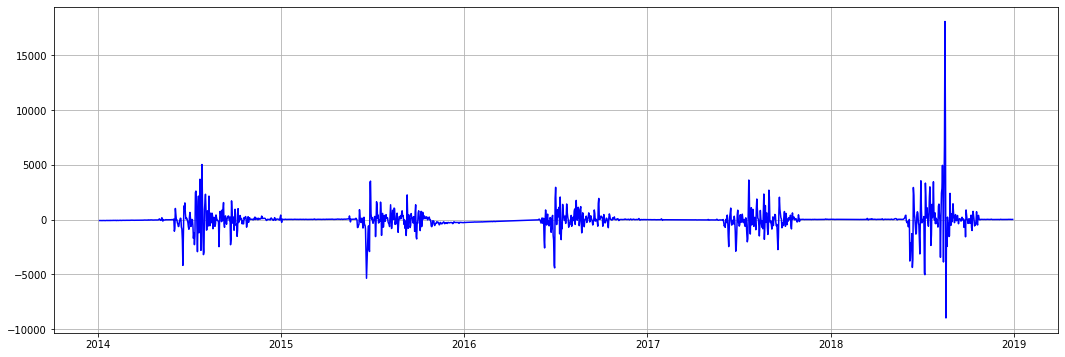

In [16]:
pt.plot(error,c= 'blue')

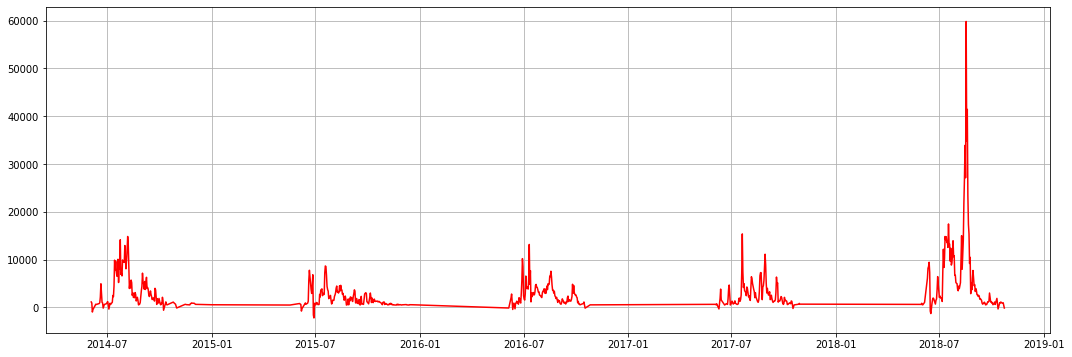

In [17]:
pt.plot(a,c='red')

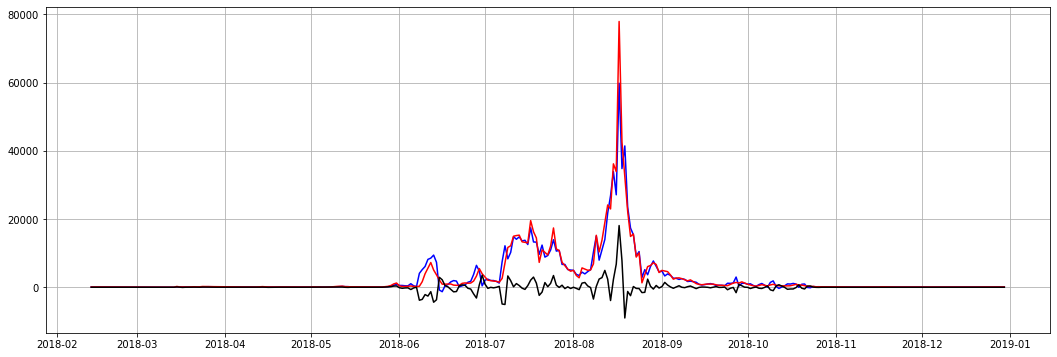

In [18]:
pt.plot(out[1500:],c='blue')
pt.plot(tar[1500:],c='red')
pt.plot(error[1500:],c='black')

In [136]:
def mean_sq_error(actuall_lst,predicted_lst):
    m = len(actuall_lst)
    error = 0
    for actuall_value,predicted_value in zip(actuall_lst,predicted_lst):
        error += (predicted_value-actuall_value)**2
    error = ((1/m) * error)   
    return error

In [137]:
def cost_calculation(predicted_value,weights,bias):
    cost = (weights*predicted_value) + bias
    return cost

In [145]:
def gradient_descent(actuall_lst,predicted_lst,weights,bias,learning_rate = 0.0005):
    epoch = 10
    gradnt_weight = 0
    gradnt_bias = 0
    m = len(actuall_lst)
    x0 = predicted_lst[0]
    for i in range(epoch):
        for actuall_value,predicted_value in zip(actuall_lst,predicted_lst):
            gradnt_weight += ((cost_calculation(predicted_value,weights,bias) - actuall_value) * x0)
            gradnt_bias += (cost_calculation(predicted_value,weights,bias) - actuall_value)
        gradnt_weight = ((1/m) * gradnt_weight)
        gradnt_bias = ((1/m) * gradnt_bias)
        
        weights = weights - (learning_rate * gradnt_weight)
        bias = bias - (learning_rate * gradnt_bias)
    value = []
    for predicted_value in predicted_lst:
        #print("Hi",weights)
        cost = cost_calculation(predicted_value,weights,bias)
        #print(cost)
        value.append(cost)
    return value

In [146]:
# import math
# print("Before RMSE = ",sqrt(metrics.mean_squared_error(tar,out)))
# print(math.sqrt(error_before))
# prediction = gradient_descent(tar,out,weights,bias)
# #print(prediction)
# print(len(prediction))
# print(len(tar))
# print("After RMSE = ",sqrt(metrics.mean_squared_error(tar,prediction)))
# #print(error_after)

Before RMSE =  901.7335837138181
901.7335837138178
1821
1821
After RMSE =  2.2527711427470806e+24


In [157]:
out_nodes = np.array(out[:1000])
input_nodes = np.array(tar[:1000])

(1000,)

In [148]:
n = len(tar)
weights = np.random.uniform(1,0,n)
bias = np.random.uniform(1,0,1)
weights
#bias

array([0.17561495, 0.22451664, 0.59062491, ..., 0.13298318, 0.27202929,
       0.98220777])

In [143]:
tar = list(tar)
out = list(out)
print(tar)
print(out)

[140.0, 136.0, 136.5, 137.0, 119.0, 123.0, 123.0, 118.0, 124.0, 121.50000762939453, 119.0, 102.0, 113.0, 124.0, 153.0, 135.0, 132.3333282470703, 129.6666717529297, 127.00000762939453, 103.0, 128.0, 119.0, 103.0, 111.0, 87.0, 103.0, 95.0, 87.0, 111.0, 95.0, 87.0, 79.0, 103.0, 71.0, 63.0, 88.0, 64.0, 64.0, 64.0, 72.0, 64.0, 56.000003814697266, 80.0, 56.000003814697266, 56.000003814697266, 56.000003814697266, 64.0, 64.0, 56.000003814697266, 56.000003814697266, 56.000003814697266, 48.499996185302734, 41.0, 49.0, 41.0, 65.0, 41.0, 41.0, 41.0, 41.0, 33.0, 33.0, 42.0, 34.0, 50.0, 46.0, 42.0, 42.0, 27.000001907348633, 26.0, 27.000001907348633, 18.0, 18.0, 18.0, 18.0, 18.0, 28.000001907348633, 20.0, 28.000001907348633, 24.0, 20.0, 20.0, 12.0, 12.0, 12.0, 12.0, 8.0, 4.0, 20.0, 20.0, 28.000001907348633, 12.0, 12.0, 16.5, 21.0, 5.0, 21.0, 51.0, 13.0, 37.0, 33.0, 28.999998092651367, 54.000003814697266, 45.0, 69.0, 45.0, 37.0, 28.999998092651367, 21.0, 21.0, 21.0, 21.0, 37.0, 21.0, 17.0, 13.0, 37.0,

In [76]:
# for a,b in zip(tar,out):
#     print(a,b)


In [ ]:
# df = pd.read_csv('/home/ganesh/Documents/Datasets/allYearHarangi.csv',header=0,parse_dates=True,index_col=0)
# df.drop(["Present Storage(TMC)",'Reservoir Level(TMC)','Outflow'],axis = 1,inplace = True)
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(df.values)
# reshaped=pd.DataFrame({'Inflow':scaled[:,0],'MADIKERI':scaled[:,1],'SOMWARPET':scaled[:,2],'VIRAJPET':scaled[:,3]})
# print(reshaped.shape)
# idx = pd.date_range('2011-01-01', '2018-12-31') 
# reshaped['Dates']=idx#reshaped.set_index(idx)
# # reshaped.index.name='Dates'
# reshaped.head()


In [ ]:
# #df = pd.read_csv('kodaguAllYearRainDam.csv')
# # df = pd.read_csv('/home/kishora/Documents/Datasets/allYearHarangi.csv')
# print(type(reshaped))
# df=reshaped
# print(df.head())
# a = "RCDATE"
# b = "Dates"
# df['month'] = pd.DatetimeIndex(df[b]).month
# df['year'] = pd.DatetimeIndex(df[b]).year
# mask = (df['month'] <= 12)
# mask1 = (df['year'] == 2013)
# df = df.loc[mask]
# print("mask ",df)
# df = df.loc[mask1]
# print("mask1 ",df)
# df.set_index(b,inplace = True)
# df.drop(['month','year'],axis = 1,inplace = True)
# #df.drop(['Inflow'],axis = 1,inplace = True)
# df

In [ ]:
# lag_val = 4

In [ ]:
# values = df.values
# values = values.astype('float32')
# # normalize features
# # scaler = MinMaxScaler(feature_range=(0, 1))
# # scaled = scaler.fit_transform(values)
# # data=pd.DataFrame({'Inflow':scaled[:,0],'MADIKERI':scaled[:,1],'SOMWARPET':scaled[:,2],'VIRAJPET':scaled[:,3]})
# # print(data.shape)
# # idx = pd.date_range('2011-01-01', '2011-12-31') 
# # data.set_index(idx)
# # frame as supervised learning
# reframed = series_to_supervised(values, lag_val, 1)#lag of 4 days
# # drop columns we don't want to predict
# reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
# reframed.head()


In [ ]:
values = reframed.values
train_x = values[:,:-1]
print(train_x)
Inflow = values[:,-1]
Inflow = Inflow.reshape((train_x.shape[0],1))

Inflow.shape
train_x.shape

In [ ]:
# #df1 = pd.read_csv('kodaguAllYearRainDam.csv')
# df1 =reshaped
# df1['month'] = pd.DatetimeIndex(df1[b]).month
# df1['year'] = pd.DatetimeIndex(df1[b]).year
# df1
# mask = (df1['month'] <= 12)
# mask1 = (df1['year'] > 2013)#&(df1['year'] <= 2018))
# df1 = df1.loc[mask]
# df1 = df1.loc[mask1]
# df1.set_index(b,inplace = True)
# df1.drop(['month','year'],axis = 1,inplace = True)
# #df1.drop(['Inflow'],axis = 1,inplace = True)
# df1

In [ ]:
# values1 = df1.values
# values1 = values1.astype('float32')
# # normalize features
# # scaler = MinMaxScaler(feature_range=(0, 1))
# # scaled = scaler.fit_transform(values1)
# # data1=pd.DataFrame({'Inflow':scaled[:,0],'MADIKERI':scaled[:,1],'SOMWARPET':scaled[:,2],'VIRAJPET':scaled[:,3]})
# # print(data1.shape)
# # idx = pd.date_range('2012-01-01', '2018-12-31') 
# # data1.set_index(idx)
# # frame as supervised learning
# reframed1 = series_to_supervised(values1, lag_val, 1)#lag of 4 days
# # drop columns we don't want to predict1
# print(reframed1.head())
# reframed1.drop(reframed1.columns[[-1,-2,-3]], axis=1, inplace=True)
# reframed1.head()


In [ ]:
# values1 = reframed1.values
# Actuall_inflow = values1[:,-1]
# test_x = values1[:,:-1]

# print(train_x.shape,Inflow.shape)
# print(test_x.shape)
# Actuall_inflow.shape

In [ ]:
# ypred = []
# train_X = train_x
# train_y = Inflow
# for i in test_x:
#     ypred.append(lwr1(i, train_X, train_y, 7.15))
# ypred = np.array(ypred).reshape(Actuall_inflow.shape[0],1)

In [ ]:
# ypred

In [ ]:
# Actuall_inflow=Actuall_inflow.reshape(Actuall_inflow.shape[0],1)

In [ ]:
# inv_yhat = np.concatenate((ypred, test_x[:, -3:]), axis=1)
# out=scaler.inverse_transform(inv_yhat) 
# out=out[:,0]
# tar_y = np.concatenate((Actuall_inflow, test_x[:, -3:]), axis=1)
# tar=scaler.inverse_transform(tar_y)
# tar=tar[:,0]

In [ ]:
# print("MSE = ",metrics.mean_squared_error(tar,out))
# print("RMSE = ",sqrt(metrics.mean_squared_error(tar,out)))
# print("RMSE = ",sqrt(metrics.mean_squared_error(tar[:-1],out[1:])))

In [ ]:
# doityourself()

In [ ]:
# pt.plot(out[1601:1691],c='blue')
# pt.plot(tar[1600:1690],c='red')

In [ ]:
# pt.plot(tar,c='red')

In [ ]:
# pt.plot(out,c='blue')